In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [12]:
### ALL NECESSARY IMPORTS ###
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

## Step 1. Camera Calibration

In [13]:

%matplotlib qt5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'output_images/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(100)

cv2.destroyAllWindows()


And now we calibrate the Camera feeding the cv2 calibrateCamera function with the lists of distorted chessboard corners, and their objpoints.

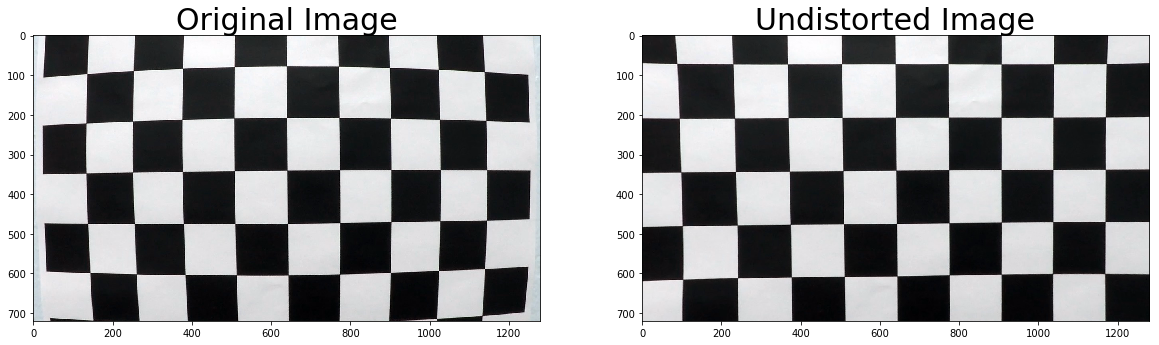

In [14]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Step 2. Applying Distorsion Correction

In [16]:
# We load the distorsion pickle file data obtained in the previous section.
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images = glob.glob('./test_images/test*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    result = img
    
    write_name = './output_images/undist' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, result)


## Step 3. Color & Gradient Thresholds --> Binary Image

First, we define the color and gradient threshold functions that we have seen during the lessons, so that later we can experiment with different combinations of them.

In [3]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    r,g,b = cv2.split(img)
    gray = np.uint8(.5*r+.5*g)

    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[ (s_channel >= sthresh[0]) & (s_channel <= sthresh[1]) ] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[ (v_channel >= vthresh[0]) & (v_channel <= vthresh[1]) ] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output


Now we obtain the preprocessed binary image a combination of GRAD_X AND GRAD_Y and the result we make an OR with Color Threshold.

In [4]:
def detect_line_borders(img):
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient = 'x', thresh=(12,255))  # 12
    grady = abs_sobel_thresh(img, orient = 'y', thresh=(25,255))  # 25
    mag = mag_thresh(img, thresh=(10,255))
    dirth = dir_threshold(img, thresh=(0.85, 1.15))
    c_binary = color_threshold(img, sthresh=(105,255), vthresh= (205,255))
    
    preprocessImage[(c_binary == 1) ] = 255
    
    preprocessImage[(c_binary == 1) |((gradx == 1)&(grady ==1)) | ((dirth ==1)&(mag == 1))] = 255
    
    return preprocessImage

### Test of Step 3

We test the function above with the provided test images undistorted.

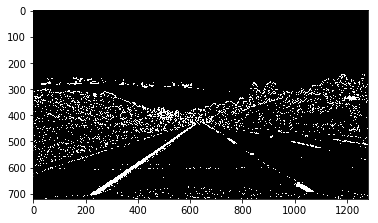

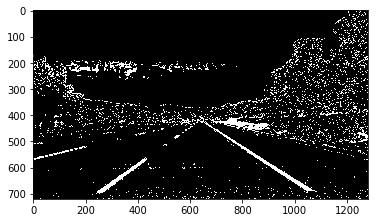

In [17]:
undist_images = glob.glob('./output_images/undist*.jpg')

for idx, fname in enumerate(undist_images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    preprocessImage = detect_line_borders(img)

    write_name = './output_images/binary' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, preprocessImage)
    
    plt.imshow(preprocessImage, cmap='gray')
    plt.show()


## Step 4. Perspective Transform

In [28]:
src = np.float32([
#    [577,460],
#    [710,460],
#    [260,684], 
#    [1070,684]])
   
    [593,450],
    [691,450],
    [260,684], 
    [1070,684]])
#274,670   1047, 670

dst = np.float32([
    [320,0],
    [960,0],
    [320,720],
    [960,720]])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

def perspective_transform_warp(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img,M,img_size)

def perspective_transform_unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img,Minv,img_size)
    

We test the function above with the test images previously processed (binaries)

Warped original undistorted color images are shown just for reference


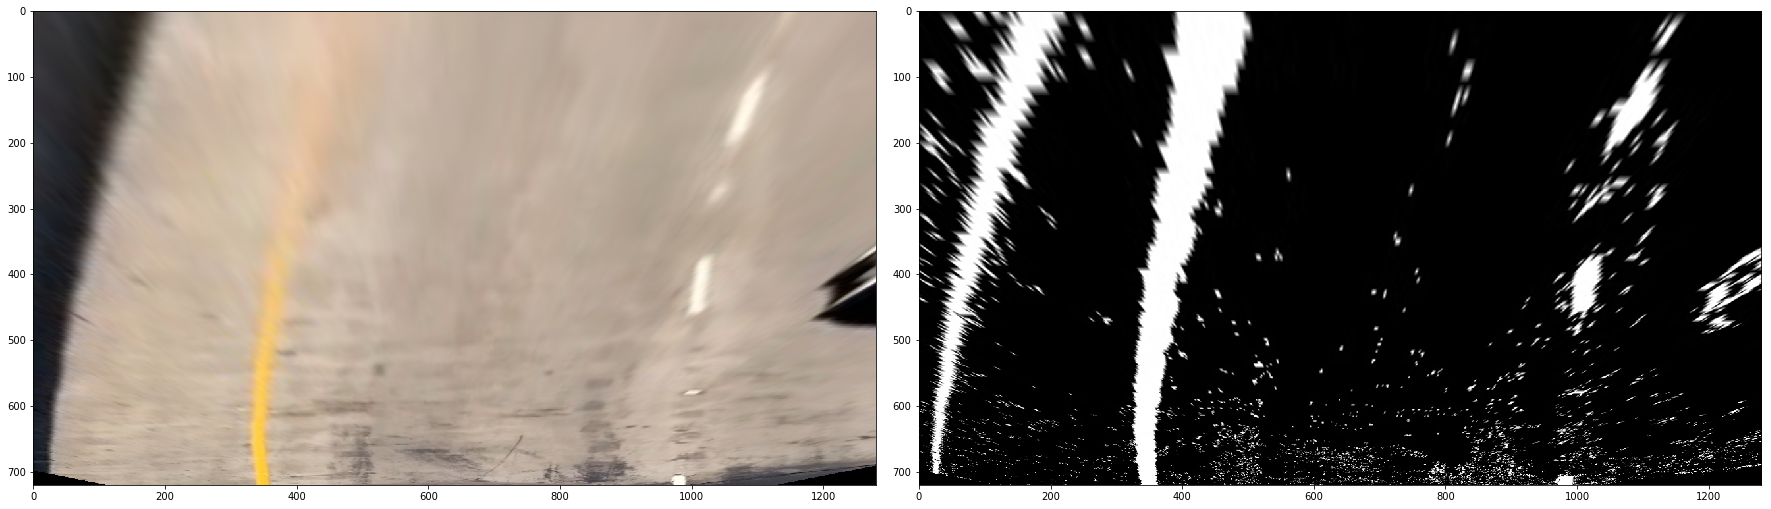

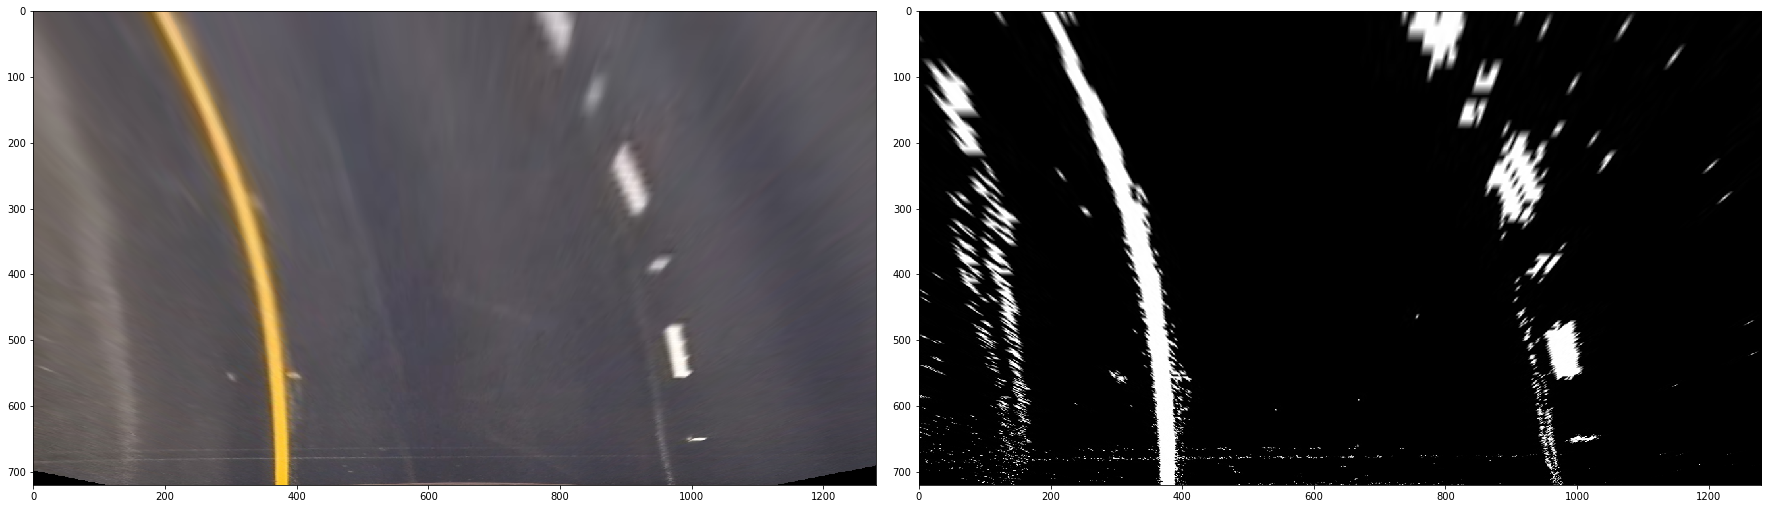

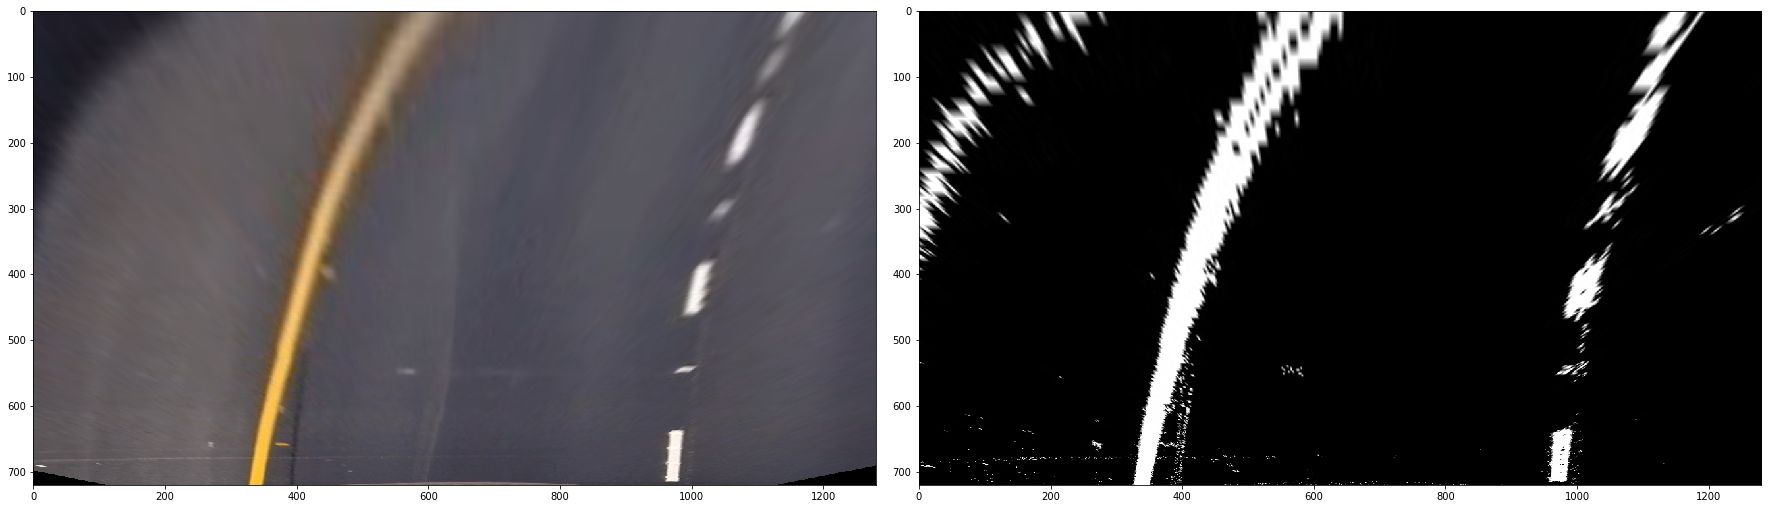

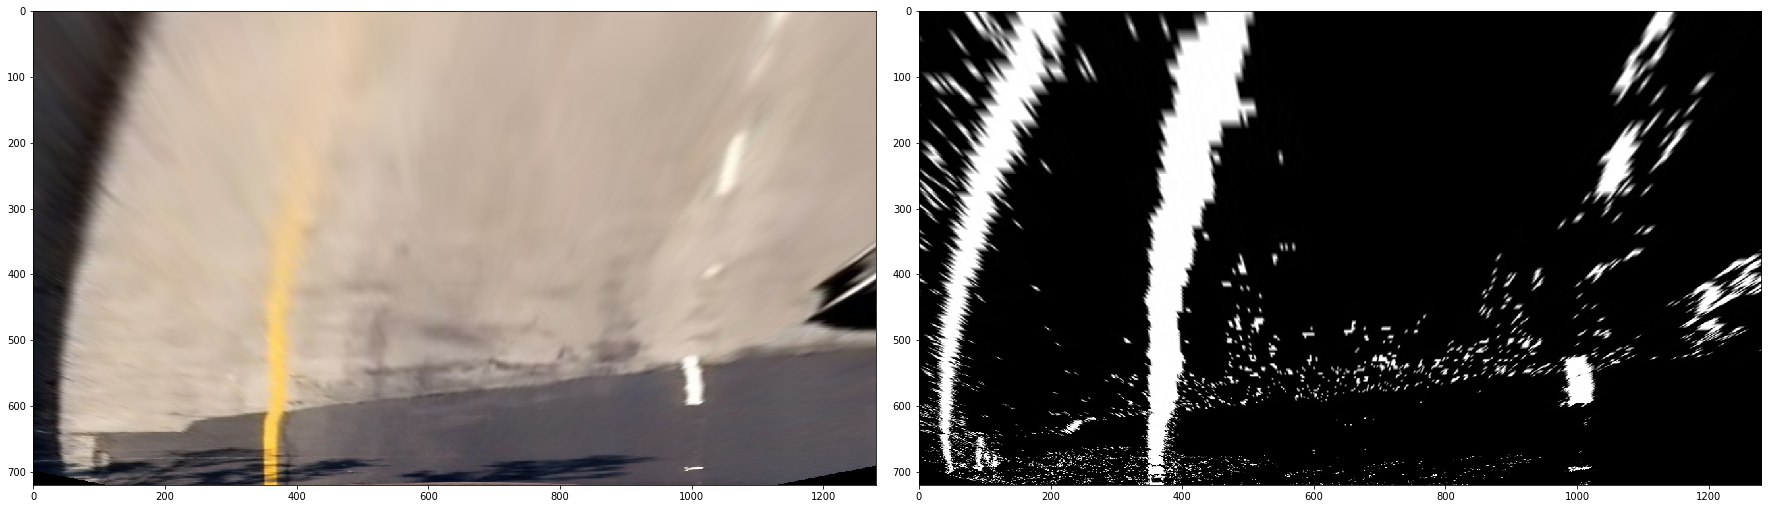

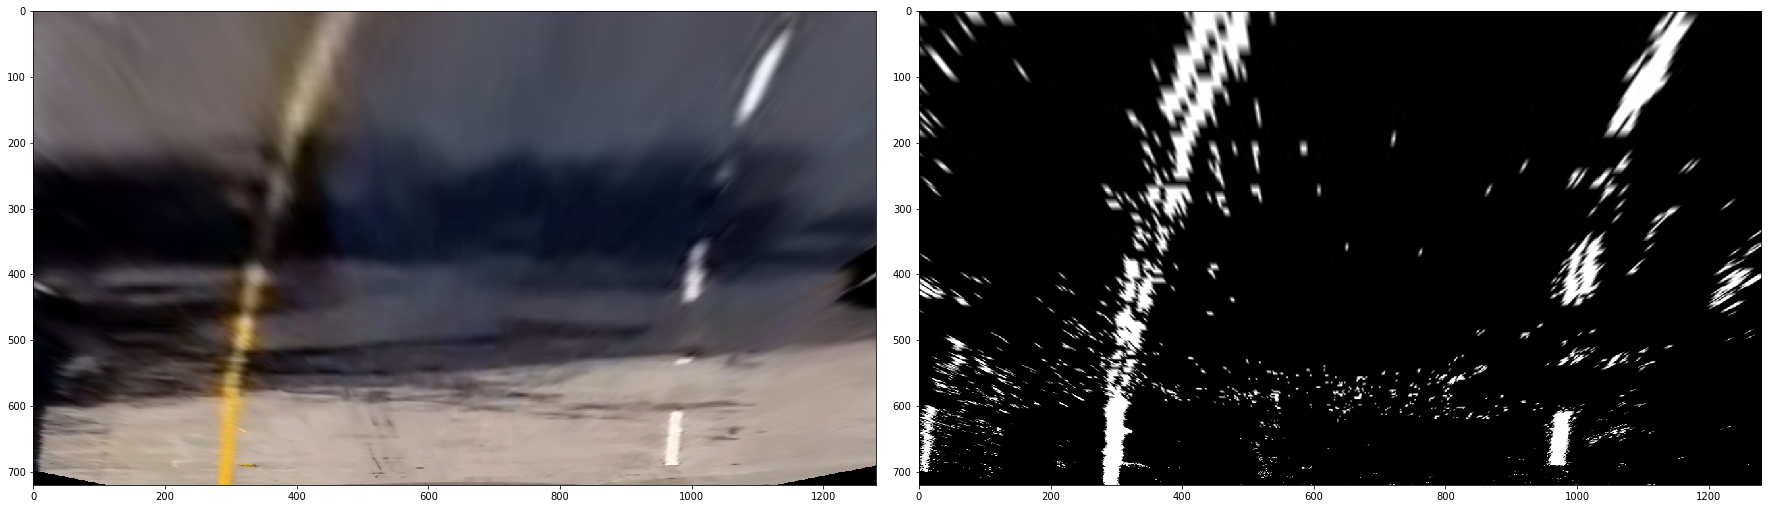

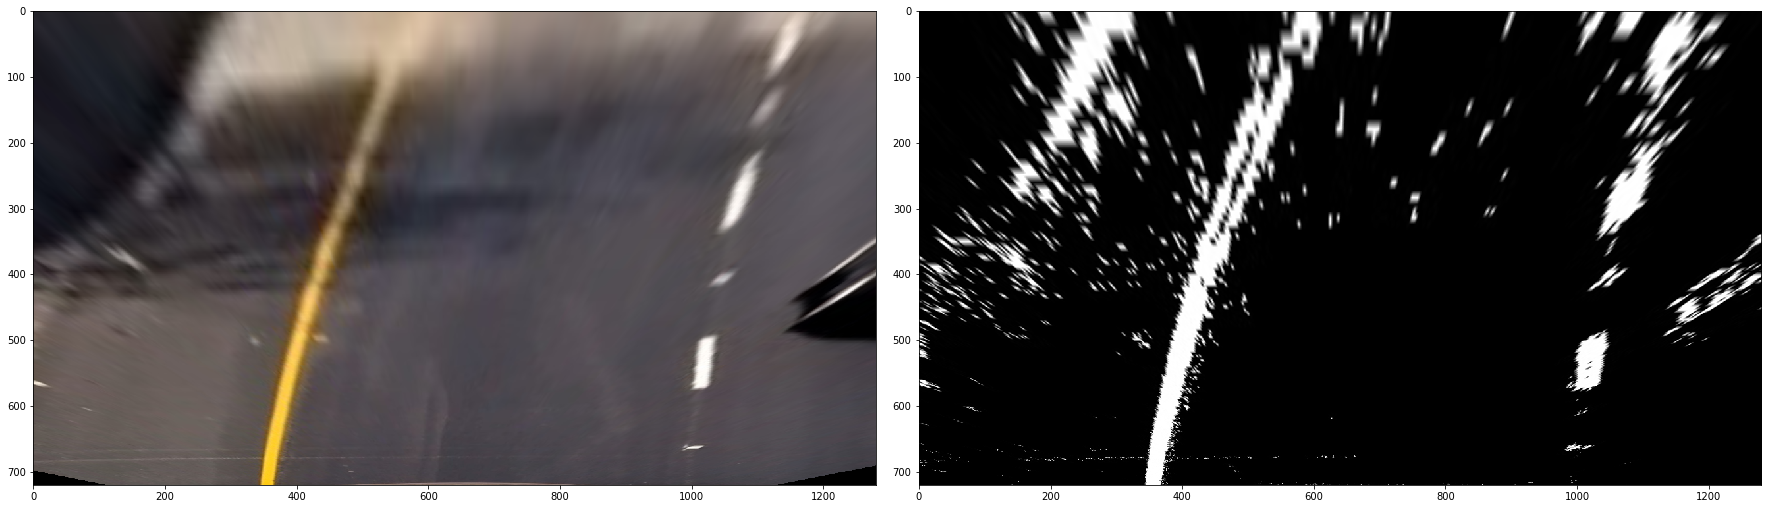

In [30]:

binary_images = glob.glob('./output_images/binary*.jpg')
undist_warped = glob.glob('./output_images/undist*.jpg')
print("Warped original undistorted color images are shown just for reference")
for idx, fname in enumerate(zip(binary_images,undist_warped)):
    binary = cv2.imread(fname[0])
    binary = binary[:,:,0]
    
    undist = image = mpimg.imread(fname[1])

    binary_warped = perspective_transform_warp(binary)
    undist_warped = perspective_transform_warp(undist)
    
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
    f.tight_layout()
    ax1.imshow(undist_warped)
    ax2.imshow(binary_warped,cmap='gray')
    plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)
    plt.show()
    write_name = './output_images/warped' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, binary_warped)


## Step 5. Detect Lines

In [31]:
import tracker
import line

warped_images = glob.glob('./output_images/warped*.jpg')
undist_images = glob.glob('./output_images/undist*.jpg')

for idx, fname in enumerate(zip(warped_images, undist_images)):
    warped = cv2.imread(fname[0])
    warped = warped[:,:,0]
    undist = cv2.imread(fname[1])
    
    # Set up the overall class to do all the tracking
    
    window_width = 40
    window_height = 80
    margin = 100    
    ym = 40/720
    xm = 3.7/700
    smooth_factor = 15

    
    curve_centers = tracker.Tracker(window_width, window_height, margin, ym, xm, smooth_factor)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    left_line_track = line.Line(warped.shape, window_height, window_width)
    right_line_track = line.Line(warped.shape, window_height, window_width)
    
    # Points to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    
    left_line_track.update_centroids(window_centroids[:,0])
    right_line_track.update_centroids(window_centroids[:,1])
        
    
    yvals = range(0, warped.shape[0])
    
    #res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    
    left_fitx, _ = left_line_track.line_fit()
    right_fitx, _ = right_line_track.line_fit()
    
    y_eval = np.max(yvals)
    
    left_lane = left_line_track.get_lane_for_drawing()
    right_lane = right_line_track.get_lane_for_drawing()
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image 
    road = np.zeros_like(undist)
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, np.int_([pts]), (0,255, 0))
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undist ,1.0, road_warped, 0.5, 0.0)
    
    #calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[1])/2
    center_diff = (camera_center-warped.shape[1]/2)* xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'
    
    print('Vehicle is '+ str(abs(round(center_diff,3))) + 'm ' + side_pos + 'off center')
    
    write_name = './output_images/result' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, result)
    
    # Plot up the sliding windows and calculated lanes
    mark_size = 3
    plt.imshow(result)
    plt.show()

    

NameError: name 'xm_per_pix' is not defined

# BACKUP:

[ 344.  343.  352.  362.  380.  394.  415.  408.  437.]
3215.45489377 m 708.52459384 m
Vehicle is 0.542m leftoff center


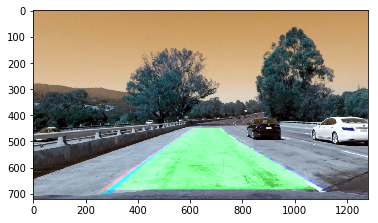

[ 374.  372.  365.  353.  335.  310.  284.  251.  218.]
775.623453592 m 433.321631996 m
Vehicle is 0.333m rightoff center


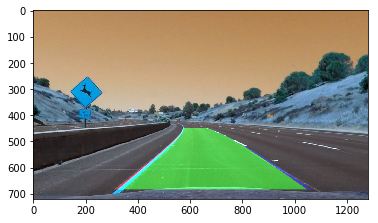

[ 354.  360.  381.  402.  423.  451.  485.  521.  561.]
909.770062754 m 1011.46904515 m
Vehicle is 0.587m leftoff center


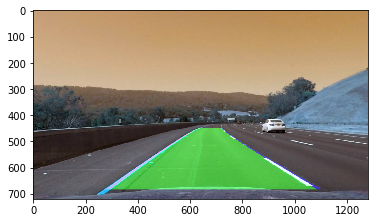

[ 362.  364.  370.  371.  386.  402.  408.  456.  468.]
911.143280518 m 1198.14487266 m
Vehicle is 0.558m leftoff center


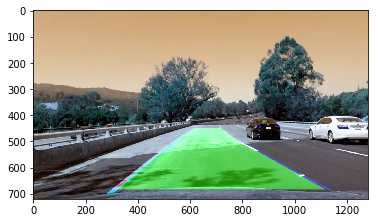

[ 296.  299.  314.  328.  334.  383.  402.  403.  425.]
2845.19378242 m 805.659758936 m
Vehicle is 0.41m leftoff center


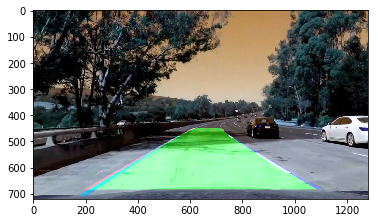

[ 371.  378.  396.  416.  441.  473.  519.  549.  587.]
838.233216007 m 1059.87881279 m
Vehicle is 0.663m leftoff center


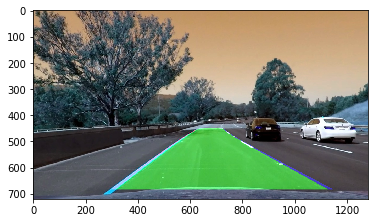

In [34]:
import tracker

warped_images = glob.glob('./output_images/warped*.jpg')
undist_images = glob.glob('./output_images/undist*.jpg')

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

for idx, fname in enumerate(zip(warped_images, undist_images)):
    warped = cv2.imread(fname[0])
    warped = warped[:,:,0]
    undist = cv2.imread(fname[1])
    
    img_size = (undist.shape[1], undist.shape[0])
    
    # Set up the overall class to do all the tracking
    
    window_width = 30
    window_height = 80
    margin = 50    
    ym = 40/720
    xm = 3.7/700
    smooth_factor = 15

    
    curve_centers = tracker.Tracker(window_width, window_height, margin, ym, xm, smooth_factor)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # points used to find the left and right lanes
    rightx = []
    leftx = []
    
    #print(window_centroids.shape)
    #print(window_centroids)
    print(window_centroids[:,0])
    
    # Go through each kevek abd draw the windows
    for level in range (0, len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1],level)
        
        # Add center value found in frame to the list of lane points per left,right:
        
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
        # Add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | (l_mask ==1) ] = 255
        r_points[(r_points == 255) | (r_mask ==1) ] = 255
        
    # DEBUG
    # Draw the results
    template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)), np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    write_name = './output_images/slidewin' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, result)
    
    
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    y_eval = np.max(yvals)
    
    # Calculate Radius in pixels
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Radius in Meters
    # Fit new polynomials to x,y in world space
    ym_per_pix = ym
    xm_per_pix = xm
    
    left_fit_cr = np.polyfit(res_yvals*ym_per_pix, np.asarray(leftx)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(res_yvals*ym_per_pix, np.asarray(rightx)*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    
    # Calculate the lane lines for the unwarped image
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0)
                                 ,np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0)
                                 ,np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0)
                                 ,np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image 
    road = np.zeros_like(undist)
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, np.int_([pts]), (0,255, 0))
    
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undist ,1.0, road_warped, 0.5, 0.0)
    
    #calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[1])/2
    center_diff = (camera_center-warped.shape[1]/2)* xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'
    
    print('Vehicle is '+ str(abs(round(center_diff,3))) + 'm ' + side_pos + 'off center')
    
    write_name = './output_images/result' + str(idx+1) + '.jpg'
    cv2.imwrite(write_name, result)
    
    # Plot up the sliding windows and calculated lanes
    mark_size = 3
    plt.imshow(result)
    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)
    #plt.plot(left_fitx, yvals, color='red', linewidth=3)
    #plt.plot(right_fitx, yvals, color='red', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images
    plt.show()

    

# Pipeline

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
import tracker
import line

window_width = 30
window_height = 80
margin = 75    
ym = 40/720
xm = 3.7/700
smooth_factor_centroids = 10
smooth_factor_polynoms = 5
img_shape = (720,1280,3)

curverad = 0

#Instantiate tracker Class object that will process all the frames in the sequence
pipeline_tracker = tracker.Tracker(window_width, window_height, margin, ym, xm, smooth_factor_centroids)
pipeline_left_lane = line.Line(img_shape, window_height, window_width, ym, xm, smooth_factor_polynoms)
pipeline_right_lane = line.Line(img_shape, window_height, window_width, ym, xm, smooth_factor_polynoms)

# We load the distorsion pickle file data obtained in section 'Step 1' above
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def process_frame(image):

    img_size = (image.shape[1], image.shape[0])

    # STEP 1. UNDISTORT
    ###################
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # STEP 2. LANE LINES BORDERS DETECTION (BINARY)
    ###############################################
    binary_img = detect_line_borders(undist_img)
    
    # STEP 3. PERSPECTIVE TRANSFORM
    ###################################################
    warped_img = perspective_transform_warp(binary_img)
    
    # STEPS 4,5,6. DETECT AND FIT LINES
    ###################################################
    yvals = range(0, warped_img.shape[0])
    
    window_centroids = pipeline_tracker.find_window_centroids(warped_img)
    pipeline_left_lane.update_centroids(window_centroids[:,0])
    pipeline_right_lane.update_centroids(window_centroids[:,1])
    
    left_fitx, _ = pipeline_left_lane.line_fit()
    right_fitx, _ = pipeline_right_lane.line_fit()
    
    left_lane_polygon = pipeline_left_lane.get_lane_for_drawing()
    right_lane_polygon = pipeline_right_lane.get_lane_for_drawing()
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    left_curverad = pipeline_left_lane.get_line_curvature()
    right_curverad = pipeline_right_lane.get_line_curvature()
    
    curverad = (left_curverad + right_curverad) / 2.0
    
    #calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[1])/2
    center_diff = (camera_center-warped_img.shape[1]/2)* xm
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'
    
    # Draw the lane onto the warped blank image 
    road = np.zeros_like(image)
    cv2.fillPoly(road, [left_lane_polygon], color=[255,0,0])
    cv2.fillPoly(road, [right_lane_polygon], color=[0,0,255])
    cv2.fillPoly(road, np.int_([pts]), (0,255, 0))

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(undist_img ,1.0, road_warped, 0.5, 0.0)
    
    # Draw the text showing curvature and offset
    cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'m ',(50,50)
                ,cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is ' + str(abs(round(center_diff, 3))) +'m '+side_pos+' of center',
                (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0),2)
    
    
    
    return result

Try the pipeline with the provided video 'project_video.mp4'

In [8]:
output_file = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(process_frame)
%time output_clip.write_videofile(output_file, audio=False)



[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [06:01<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 5min 48s, sys: 1min 14s, total: 7min 3s
Wall time: 6min 2s
